# **Tugas Besar ML Bagian D**
---
### Anggota
1. M. Khairul Makirin - 13517088
2. Avisenna Abimanyu - 13517010
3. Muhammad Fariz Lutfan Wakan - 13517034
4. Ihsan Azhar Imaduddin - 13517043



## **Pre-process Iris Dataset**

In [0]:
from sklearn.datasets import load_iris

### **Split Train-Test Scheme**
Train : 90%

Test : 10%

In [0]:
from sklearn.model_selection import train_test_split

iris_dataset = load_iris()
irisTrainInstances, irisTestInstances, irisTrainTargets, irisTestTargets = train_test_split(iris_dataset.data, iris_dataset.target, test_size=0.1)

### **K-Fold Cross Validation Scheme**
K = 10


In [0]:
K = 10

## **Multi Layer Perceptron**


In [0]:
import math
import numpy as np
import pickle 


class MiniBatchGradientMLP:
  def __init__(self, nodesArr, batchSize):
    self.batchSize = batchSize
    self.layers = [Layer(nbNodes) for nbNodes in nodesArr]
    np.random.seed(2)
    self.weights = [np.random.rand(nodesArr[i]+1, nodesArr[i+1])-0.5 for i in range(len(nodesArr)-1)] #ditambah 1 untuk biasnya

  @classmethod
  def initFromFile(self, filename):
    self.load_mlp(self, filename)

  def load_mlp(self,name):
      #load layer
      layerFilehandler = open(name+'_layers.pickle', 'rb') 
      self.layers = pickle.load(layerFilehandler)
      #load weight
      weightFilehandler = open(name+'_weights.pickle', 'rb') 
      self.weights = pickle.load(weightFilehandler)
      #load batch size
      batchSizeFileHandler = open(name+'_batchsize.pickle', 'rb')
      self.batchSize = pickle.load(batchSizeFileHandler)
      

  def save_mlp(self,name):
      #save layer
      layerFilehandler = open(name+'_layers.pickle', 'wb') 
      pickle.dump(self.layers, layerFilehandler)
      #save weight
      weightFilehandler = open(name+'_weights.pickle', 'wb') 
      pickle.dump(self.weights, weightFilehandler)
      #save batch size
      batchSizeFilehandler = open(name+'_batchsize.pickle', 'wb') 
      pickle.dump(self.batchSize, batchSizeFilehandler)

  def train(self, trainingData, trainingTarget, epochs, learningRate, minCumulativeError):
    trainingHistory = {
        "Epochs" : epochs,
        "MinCumulativeError" : minCumulativeError,
        "LearningRate" : learningRate,
        "CumulativeError" : [],
        "Accuracy" : []
    }

    nbData = len(trainingData)
    nbFeature = len(trainingData[0])

    for i in range(epochs):
      accuracy = 0
      cumulativeError = 0
      count = 0
      globalDeltaW = [np.zeros((self.layers[i].nbNodes+1, self.layers[i+1].nbNodes)) for i in range(len(self.layers)-1)]

      #iterasi tiap training data
      for j in range(nbData):
        inputs = trainingData[j]
        target = trainingTarget[j]

        output = self.feedForward(inputs)
        totalError = self.calcTotalError(output, target)
        cumulativeError += totalError

        localDeltaW = self.backwardProp(target, learningRate)

        #akumulasi deltaWeight
        for k in range(len(localDeltaW)):
          globalDeltaW[k] += localDeltaW[k]

        #update akurasi
        if np.argmax(output) == np.argmax(target):
          accuracy += 1

        #update weights jika sudah batch size
        if count == self.batchSize or i == epochs-1:
          count = 0
          for k in range(len(self.weights)):
            self.weights[k] += globalDeltaW[k]
          globalDeltaW = [np.zeros((self.layers[i].nbNodes+1, self.layers[i+1].nbNodes)) for i in range(len(self.layers)-1)]
        
        count += 1

      #update training history
      trainingHistory["CumulativeError"].append(cumulativeError)
      trainingHistory["Accuracy"].append(accuracy/nbData)
      # trainingHistory["Accuracy"].append(accuracy/nbData)
      print("Epoch : {:d}\tCumulative Error : {:f}\tAccuracy : {:f}".format(i+1, cumulativeError, accuracy/nbData))

      #jika cumulative error nya udah lebih kecil dari minCumulativeError
      if cumulativeError <= minCumulativeError:
        break

    return trainingHistory
    
  def predict(self, instances):
    results = []
    for instance in instances:
      res = self.feedForward(instance)
      idx = np.argmax(res)
      results.append(idx)

    return results #list of numpy array
  
  def calcTotalError(self, outputs, targets):
    errors = 0
    for i in range(len(targets)):
      errors += math.pow((targets[i]-outputs[i]), 2)

    return errors*0.5

  def feedForward(self, inputs, pr=False):
    if len(inputs) != self.layers[0].nbNodes:
      raise ValueError("Shape of input ({:d}) does not match number of nodes ({:d})".format(len(inputs), self.layers[0].nbNodes))
    else:
      self.layers[0].outputs = np.array(inputs)
      instance = inputs
      for i, layer in enumerate(self.layers[1:]):
        instance = np.append(instance, 1) #biasnya
        val = np.dot(instance, self.weights[i])
        if pr:
          print(val, i)
        instance = layer.compute(val)

    return instance

  def backwardProp(self, targets, learningRate):
    deltaWeights = [np.zeros((self.layers[i].nbNodes+1, self.layers[i+1].nbNodes)) for i in range(len(self.layers)-1)]

    ##cari deltaNode untuk tiap node di tiap layer (kecuali input)
    for i in range(len(self.layers)-1, 0, -1):
      currLayer = self.layers[i]

      #hitung untuk output layer
      if i == len(self.layers)-1:
        for j in range(currLayer.nbNodes):
          outputK = currLayer.outputs[j]
          self.layers[i].deltas[j] = outputK*(1-outputK)*(targets[j]-outputK)
      
      #hitung untuk hidden layer
      else:
        for j in range(currLayer.nbNodes):
          outputH = currLayer.outputs[j]
          self.layers[i].deltas[j] = outputH*(1-outputH)*np.dot(self.weights[i][j], self.layers[i+1].deltas)
    
    ##cari deltaW nya untuk tiap weight
    for n in range(len(deltaWeights)):
      outputs = self.layers[n].outputs
      deltas = self.layers[n+1].deltas
      
      partialRes = []
      for output in outputs:
        for delta in deltas:
          partialRes.append(output*delta)

      for delta in deltas:
        partialRes.append(delta)

      i = 0
      for row in range(len(deltaWeights[n])):
        for col in range(len(deltaWeights[n][row])):
          deltaWeights[n][row][col] = partialRes[i]*learningRate
          i += 1

    return deltaWeights

In [0]:
class Layer:
  def __init__(self, nbNodes):
    self.nbNodes = nbNodes
    self.outputs = np.zeros(nbNodes) #+1 untuk node bias
    self.inputs = np.zeros(nbNodes)
    self.deltas = np.zeros(nbNodes)
  
  def activationFunction(self, y):
    ## Fungsi sigmoid
    return 1/(1+math.exp(-y))
  
  # Return sebuah numpy array yang sizenya sama dengan nbNodes
  def compute(self, inputArr):
    if len(inputArr) > self.nbNodes:
      raise ValueError("Shape of input ({:d}) does not match number of nodes ({:d})".format(len(inputArr), self.nbNodes))
    else:
      self.inputs = np.array(inputArr)
      self.outputs = np.array([self.activationFunction(y) for y in inputArr])
      return self.outputs

## **Decision Tree Learning**

In [0]:
from math import log2
import pandas


class Node:

    def __init__(self, attribute=None, instances=[], targets=[]):
        self.rule_children = {}     #dictionary yang berisi string (rule) sebagai key-nya dan objek Node sebagai valuenya
        self.attribute = attribute  #integer, index atribut yang dicek pada node tersebut, index dimulai dari 0
        self.instances = instances  #array yang menyimpan instans
        self.targets = targets      #array yang menyimpan target
        self.entropy = DecisionTree.entropy(targets)
        self.target = None
    
    def next_node(self, X):
        if self.attribute != None:
            for rule in self.rule_children.keys():
                if eval("X[" + str(self.attribute) + "] " + rule):
                    return self.rule_children[rule]
        
        return Node()
            
    def set_rule_children(self, str_rules, children_nodes):
        for i, str_rule in enumerate(str_rules):
            self.rule_children[str_rule] = children_nodes[i]

    def calc_entropy(self):
        s = len(self.instances) #Banyaknya instans
        sv = {}                 #Menyimpan banyaknya instans dari kelas tertentu
        entropy = 0             #Variabel sum

        for target in self.targets:
            if target in sv.keys():
                sv[target] += 1
            else:
                sv[target] = 1

        for target in self.targets:
            p = sv[target]/s
            entropy += -1*(p)*log2(p)

        return entropy

    ## return kelas terbanyak
    def calc_target(self):
        num = {}

        for target in self.targets:
            if target not in num.keys():
                num[target] = 0
            else:
                num[target] += 1

        max_num = 0
        final_target = None
        for target, val in num.items():
            if val >= max_num:
                max_num = val
                final_target = target

        return final_target 

    def print_node(self):
        print("RULE_CHILDREN ->",self.rule_children)
        print("ATTRIBUTE ->",self.attribute)
        print("INSTANCES ->",self.instances)
        print("TARGETS ->",self.targets)
        print("ENTROPI ->" , self.entropy)
        print("TARGET ->", self.target, "\n")

class DecisionTree():

    def __init__(self, arr_instans, arr_target):
        self.instances = arr_instans
        self.targets = arr_target
        self.root = None

    def fit(self, instances, targets):
        pass
    
    def predict(self, instances):
        pass

    @staticmethod
    def entropy(targets):
        s = len(targets) #Banyaknya instans
        sv = {}          #Menyimpan banyaknya instans dari kelas tertentu
        entropy = 0      #Variabel sum

        for target in targets:
            if target in sv.keys():
                sv[target] += 1
            else:
                sv[target] = 1

        for target in targets:
            p = sv[target]/s
            entropy += -1*(p)*log2(p)

        return entropy

    @staticmethod
    def information_gain(parent_ent, S,  list_targets):
        gain = parent_ent

        for targets in list_targets:
            gain -= len(targets)*DecisionTree.entropy(targets)/S

        return gain
    
    @staticmethod
    def getTrainColLength(arr_instans):
        count=0
        for i in arr_instans[0]:
            count+=1
        return count
    
    @staticmethod
    def getTrainRowLength(arr_instans):
        count=0
        for i in arr_instans:
            count+=1
        return count

    @staticmethod
    def save_dtl(dtl_object,name):
        filehandler = open(name+'_dtl.pickle', 'w') 
        pickle.dump(dtl_object, filehandler)

    @staticmethod
    def load_dtl(name):
        # will return saved object
        filehandler = open(name+'_dtl.pickle', 'r') 
        return pickle.load(filehandler)




In [0]:
class ID3(DecisionTree):
    def __init__(self, arr_instans, arr_target, max_depth):
        DecisionTree.__init__(self, arr_instans, arr_target)
        self.max_depth = max_depth
        self.depth = 0
        

    def predict(self, instances):
        predictions = []
        for instance in instances:
            root = self.root
            while root.attribute != None:
                root = root.next_node(instance)
            predictions.append(root.target)
        return predictions

    def fit(self, arr_instans, arr_target):
        node_p = Node(instances=arr_instans,targets=arr_target)
        
        if (node_p.entropy==0 or self.depth >= self.max_depth):
            node_p.target = node_p.calc_target()
            node_p.print_node()

            return node_p
        else:
            row = DecisionTree.getTrainRowLength(arr_instans)
            col = DecisionTree.getTrainColLength(arr_instans)

            #mencari atribut terbaik dari instans
            max_gain = 0 # value gain
            node_p.attribute = 0 # index col gain idx_gain

            ic(arr_instans)
            ic(arr_target)

            for j in range(col):
                dict_attrval_targets = {}

                for i in range(row):
                    curr_val = arr_instans[i][j]
                    if curr_val in dict_attrval_targets.keys():
                        dict_attrval_targets[curr_val].append(arr_target[i])
                    else:
                        dict_attrval_targets[curr_val] = [arr_target[i]]
                gain = self.information_gain(node_p.entropy, len(arr_instans), dict_attrval_targets.values())
                ic(dict_attrval_targets)
                ic(dict_attrval_targets.values())
                ic(gain)

                if (max_gain < gain):
                    max_gain = gain
                    node_p.attribute = j

                ic(max_gain)
                ic(node_p.attribute)

            #membentuk list rules dan membagi instances dan targets kedalam children nodesnya
            rules = []
            attr_val = []
            new_instances_targets = {}

            for i, instance in enumerate(arr_instans):
                curr_val = instance[node_p.attribute]

                if curr_val not in attr_val:
                    attr_val.append(curr_val)
                    rules.append(" == " + str(curr_val))

                if curr_val not in new_instances_targets.keys():
                    new_instances_targets[curr_val] = [[instance], [arr_target[i]]]
                else:
                    new_instances_targets[curr_val][0].append(instance)
                    new_instances_targets[curr_val][1].append(arr_target[i])

            ic(rules)
            ic(attr_val)
            ic(new_instances_targets)

            #membentuk node childrennya
            childrens = []
            for instances_targets in new_instances_targets.values():
                self.depth += 1
                childrens.append(self.fit(instances_targets[0], instances_targets[1]))

            #set rules children untuk nope_p
            node_p.set_rule_children(rules, childrens)
            node_p.print_node()

            self.root = node_p

            return node_p

## **Train-Test Split Configuration Testing**

### **Artificial Neural Network**
#### **Factors :**
1. Number of hidden layers
2. Number of nodes per hidden layers
3. Learning rate
4. Epochs

#### **Strategy :** One factor at a time

Epoch : 1	Cumulative Error : 48.622915	Accuracy : 0.318519
Epoch : 2	Cumulative Error : 47.710357	Accuracy : 0.318519
Epoch : 3	Cumulative Error : 47.029725	Accuracy : 0.318519
Epoch : 4	Cumulative Error : 46.524604	Accuracy : 0.318519
Epoch : 5	Cumulative Error : 46.150110	Accuracy : 0.318519
Epoch : 6	Cumulative Error : 45.872025	Accuracy : 0.318519
Epoch : 7	Cumulative Error : 45.664886	Accuracy : 0.318519
Epoch : 8	Cumulative Error : 45.509984	Accuracy : 0.281481
Epoch : 9	Cumulative Error : 45.393649	Accuracy : 0.340741
Epoch : 10	Cumulative Error : 45.305896	Accuracy : 0.340741
Epoch : 11	Cumulative Error : 45.239418	Accuracy : 0.340741
Epoch : 12	Cumulative Error : 45.188848	Accuracy : 0.340741
Epoch : 13	Cumulative Error : 45.150227	Accuracy : 0.340741
Epoch : 14	Cumulative Error : 45.120617	Accuracy : 0.340741
Epoch : 15	Cumulative Error : 45.097831	Accuracy : 0.340741
Epoch : 16	Cumulative Error : 45.080231	Accuracy : 0.340741
Epoch : 17	Cumulative Error : 45.066583	Accuracy 

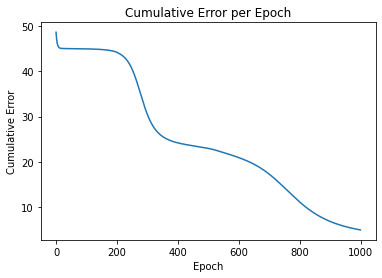

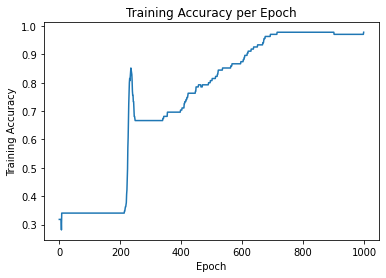

In [0]:
## konfigurasi dibawah didapatkan dari hasil eksperimen dengan skema Train-Test Split

import matplotlib.pyplot as plt

## transforming output target
trainTarget = []
for target in irisTrainTargets:
  if target == 0 :
    trainTarget.append([1, 0, 0])
  elif target == 1 :
    trainTarget.append([0, 1, 0])
  elif target == 2 :
    trainTarget.append([0, 0, 1])

## start training
EPOCHS = 1000
LEARNING_RATE = 0.011
MIN_CERROR = 0.01

myMLP = MiniBatchGradientMLP([4, 3, 3, 3], 5)
trainHistory = myMLP.train(irisTrainInstances, trainTarget, EPOCHS, LEARNING_RATE, MIN_CERROR)

## calculating performance based on test data
predicted = myMLP.predict(irisTestInstances)
accuracy = 0
for i in range(len(predicted)):
  if predicted[i] == irisTestTargets[i]:
    accuracy += 1
print("Accuracy : {:f}".format(accuracy/len(irisTestTargets)))
print("Predicted values : ", predicted)
print("Ground truths values : ", irisTestTargets)

plt.plot(trainHistory["CumulativeError"])
plt.title("Cumulative Error per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cumulative Error")
plt.show()

plt.plot(trainHistory["Accuracy"])
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.show()

### **Decision Tree Learning**


## **K-Fold Cross Validation Configuration Testing**

In [0]:
import matplotlib.pyplot as plt
import numpy as np

EPOCHS = 200
LEARNING_RATE = 0.021
MIN_CERROR = 0.01

def getValidation(seq, num, i):
    avg = len(seq) / float(num)
    train = []
    validation = []
    last = 0.0

    while last < len(seq):
        if i == 0:
            validation = seq[int(last):int(last + avg)]
        else:
            if train == []:
                train = seq[int(last):int(last + avg)]
            else:
                train = np.concatenate((train, seq[int(last):int(last + avg)]))
        last += avg
        i -= 1

    return (train, validation)

myMLP = MiniBatchGradientMLP([4, 3, 3, 3], 5)

for i in range(K):
    splitedTrainInstances, validationInstances = getValidation(irisTrainInstances, K, i)
    splitedTrainTargets, validationTargets = getValidation(irisTrainTargets, K, i)

    trainTargets = []
    for target in splitedTrainTargets:
        if target == 0 :
            trainTargets.append([1, 0, 0])
        elif target == 1 :
            trainTargets.append([0, 1, 0])
        elif target == 2 :
            trainTargets.append([0, 0, 1])

    trainHistory = myMLP.train(splitedTrainInstances, trainTargets, EPOCHS, LEARNING_RATE, MIN_CERROR)

    predicted = myMLP.predict(validationInstances)
    accuracy = 0
    for i in range(len(predicted)):
        if predicted[i] == validationTargets[i]:
            accuracy += 1
    print("Accuracy : {:f}".format(accuracy/len(irisTestTargets)))
    print("Predicted values : ", predicted)
    print("Ground truths values : ", irisTestTargets)

predicted = myMLP.predict(irisTestInstances)
accuracy = 0
for i in range(len(predicted)):
  if predicted[i] == irisTestTargets[i]:
    accuracy += 1
print("Accuracy : {:f}".format(accuracy/len(irisTestTargets)))
print("Predicted values : ", predicted)
print("Ground truths values : ", irisTestTargets)

plt.plot(trainHistory["CumulativeError"])
plt.title("Cumulative Error per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cumulative Error")
plt.show()

plt.plot(trainHistory["Accuracy"])
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.show()


## **Save/Load Testing**

### **myMLP**

Epoch : 1	Cumulative Error : 4.940254	Accuracy : 0.970370
Epoch : 2	Cumulative Error : 4.929874	Accuracy : 0.970370
Epoch : 3	Cumulative Error : 4.917982	Accuracy : 0.970370
Epoch : 4	Cumulative Error : 4.906159	Accuracy : 0.970370
Epoch : 5	Cumulative Error : 4.894426	Accuracy : 0.970370
Epoch : 6	Cumulative Error : 4.882783	Accuracy : 0.970370
Epoch : 7	Cumulative Error : 4.871228	Accuracy : 0.970370
Epoch : 8	Cumulative Error : 4.859761	Accuracy : 0.970370
Epoch : 9	Cumulative Error : 4.848381	Accuracy : 0.970370
Epoch : 10	Cumulative Error : 4.837087	Accuracy : 0.970370
Epoch : 11	Cumulative Error : 4.825878	Accuracy : 0.970370
Epoch : 12	Cumulative Error : 4.814754	Accuracy : 0.970370
Epoch : 13	Cumulative Error : 4.803714	Accuracy : 0.970370
Epoch : 14	Cumulative Error : 4.792757	Accuracy : 0.970370
Epoch : 15	Cumulative Error : 4.781883	Accuracy : 0.970370
Epoch : 16	Cumulative Error : 4.771090	Accuracy : 0.970370
Epoch : 17	Cumulative Error : 4.760378	Accuracy : 0.970370
Epoch 

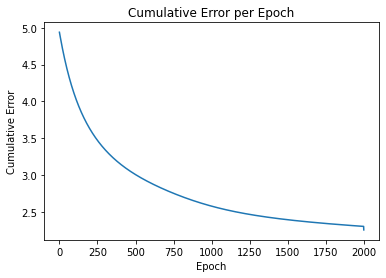

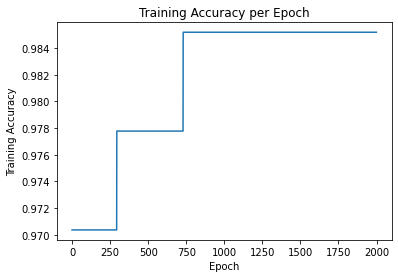

In [0]:
myMLP.save_mlp("test")

EPOCHS = 2000
LEARNING_RATE = 0.011
MIN_CERROR = 0.01

myMLP1 = MiniBatchGradientMLP.initFromFile("test")
trainHistory = myMLP.train(irisTrainInstances, trainTarget, EPOCHS, LEARNING_RATE, MIN_CERROR)

## calculating performance based on test data
predicted = myMLP.predict(irisTestInstances)
accuracy = 0
for i in range(len(predicted)):
  if predicted[i] == irisTestTargets[i]:
    accuracy += 1
print("Accuracy : {:f}".format(accuracy/len(irisTestTargets)))
print("Predicted values : ", predicted)
print("Ground truths values : ", irisTestTargets)

plt.plot(trainHistory["CumulativeError"])
plt.title("Cumulative Error per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cumulative Error")
plt.show()

plt.plot(trainHistory["Accuracy"])
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.show()